In [1]:
import os
import numpy as np
import time
import scipy.stats as stats
from scipy.special import factorial
import csv
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.multitest as sm
from fisher import pvalue_npy
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.metrics import average_precision_score
from mpl_toolkits import mplot3d
import pairmodule as pair
from imblearn.over_sampling import RandomOverSampler

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from mlxtend.feature_extraction import PrincipalComponentAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import StratifiedKFold
from joblib import dump, load

# construct CEmRNA pair

In [2]:
lmRNA = pd.read_csv('./num_lmRNA0.5.txt',sep='\t',index_col=0)
cmRNA = pd.read_csv('./num_cmRNA0.5.txt',sep='\t',index_col=0)

# lmRNA = lmRNA.drop(labels='X3',axis=1)
# cmRNA = cmRNA.drop(labels='X3',axis=1)

RNAlst = pd.DataFrame(columns = ['clRNA','mRNA1','mRNA2','type'])

lst = list(lmRNA.groupby(by='X1'))
for i in range(len(lst)):
    K = lst[i][1]
#     K = K.drop(labels = ['value'],axis=1)
    tmp = pd.merge(K,K,on='X1')
    tmp = tmp[tmp['X2_x']!=tmp['X2_y']]
    tmp = tmp[~tmp[['X2_x','X2_y']].apply(frozenset,axis=1).duplicated()]
    tmp = tmp.rename(columns={'X1':'clRNA','X2_x':'mRNA1','X2_y':'mRNA2'})
    tmp['type'] = 'lnc'

    RNAlst = RNAlst.append(tmp)


lst = list(cmRNA.groupby(by='X1'))
for i in range(len(lst)):
    K = lst[i][1]
#     K = K.drop(labels = ['value'],axis=1)
    tmp = pd.merge(K,K,on='X1')
    tmp = tmp[tmp['X2_x']!=tmp['X2_y']]
    tmp = tmp[~tmp[['X2_x','X2_y']].apply(frozenset,axis=1).duplicated()]
    tmp = tmp.rename(columns={'X1':'clRNA','X2_x':'mRNA1','X2_y':'mRNA2'})
    tmp['type'] = 'circ'

    RNAlst = RNAlst.append(tmp)

RNAlst.reset_index(drop=True,inplace=True)

In [3]:
RNAlst

,clRNA,mRNA1,mRNA2,type,value_x,value_y
0,BACE1-AS,SLC1A1,SLPI,lnc,0.7982,0.6643
1,BACE1-AS,SLC1A1,STXBP2,lnc,0.7982,0.8502
2,BACE1-AS,SLC1A1,VNN1,lnc,0.7982,0.5651
3,BACE1-AS,SLC1A1,RORA,lnc,0.7982,0.8061
4,BACE1-AS,SLC1A1,RPS3,lnc,0.7982,0.5928
...,...,...,...,...,...,...
186289,ZNF93,TYRO3,WFS1,circ,0.5020,0.7698
186290,ZNF93,TYRO3,ZNF287,circ,0.5020,0.5066
186291,ZNF93,USP20,WFS1,circ,0.6468,0.7698
186292,ZNF93,USP20,ZNF287,circ,0.6468,0.5066


# import data

In [4]:
# imulabel = pd.read_csv('./oclabel/immport.mRNA0728.txt').values
# ceRNA = pd.read_csv('./CEmRNA0.75.txt')
# ceRNA = pd.Index(ceRNA['x'])

df1 = pd.read_csv('./ocRMA/exp.mRNA.AgilentG4502A_07_2.txt',sep = "\t", index_col=0,header = 0)
df2 = pd.read_csv('./ocRMA/exp.mRNA.HT_HG-U133A.txt',sep = "\t", index_col=0,header = 0)
df3 = pd.read_csv('./ocRMA/exp.mRNA.GSE6008.RMA.txt',sep = "\t", index_col=0,header = 0)
df4 = pd.read_csv('./ocRMA/exp.mRNA.GSE18520.RMA.txt',sep = "\t", index_col=0,header = 0)
df5 = pd.read_csv('./ocRMA/exp.mRNA.GSE40595.RMA.txt',sep = "\t", index_col=0,header = 0)
df6 = pd.read_csv('./ocRMA/mRNA.validation.txt',sep = "\t", index_col=0,header = 0)
df6 = df6.drop(df6.columns[range(8,16)],axis=1)

# blood sample
df8 = pd.read_csv('./ocRMA/blood/GSE11545.txt',sep = "\t", index_col=0,header = 0)
lab8 = np.genfromtxt('./oclabel/blood/GSE11545.label.txt',dtype="U16,U16,u1")['f2']
df9 = pd.read_csv('./ocRMA/blood/GSE31682.txt',sep = "\t", index_col=0,header = 0)
df10 = pd.read_csv('./ocRMA/blood/GSE37582.txt',sep = "\t", index_col=0,header = 0)

comidx = df1.index.join(
    df2.index.join(
        df3.index.join(
            df4.index.join(
                df5.index.join(
#                     df6.index.join(ceRNA,how='inner'),how='inner')
                    df6.index,how='inner')
            ,how='inner')
        ,how='inner')
    ,how='inner')
,how='inner')


comidx = df8.index.join(df9.index.join(df10.index.join(comidx,how='inner'),how='inner'),how='inner')

df1 = df1.loc[comidx]
df2 = df2.loc[comidx]
df3 = df3.loc[comidx]
df4 = df4.loc[comidx]
df5 = df5.loc[comidx]
df6 = df6.loc[comidx]

lab1 = np.genfromtxt('./oclabel/AgilentG4502A_07_2.label.txt',dtype="U16,u1")['f1']
lab2 = np.genfromtxt('./oclabel/HT_HG-U133A.label.txt',dtype="U16,u1")['f1']
lab3 = np.genfromtxt('./oclabel/GSE6008.label.txt',dtype="U16,U16,u1")['f2']
lab4 = np.genfromtxt('./oclabel/GSE18520.label.txt',dtype="U16,U16,U16,u1,u1")['f4']
lab5 = np.genfromtxt('./oclabel/GSE40595.label.txt',dtype="U16,U16,U16,U16,U16,U16,U16,u1")['f7']
lab6 = np.genfromtxt('./oclabel/mRNA.label.txt',dtype="U16,u1")['f1']
# lab7 = np.genfromtxt('./oclabel/combat.label.txt',dtype="U16,u1")['f1']
lab6 = np.delete(lab6,range(8,16))

print(len(comidx))

8861


In [5]:
#remove ceRNA not in data comidx
RNAlst = RNAlst[(RNAlst['mRNA1'].isin(comidx))&(RNAlst['mRNA2'].isin(comidx))]
RNAlst.reset_index(drop=True,inplace=True)
RNAlst

,clRNA,mRNA1,mRNA2,type,value_x,value_y
0,BACE1-AS,SLC1A1,SLPI,lnc,0.7982,0.6643
1,BACE1-AS,SLC1A1,STXBP2,lnc,0.7982,0.8502
2,BACE1-AS,SLC1A1,VNN1,lnc,0.7982,0.5651
3,BACE1-AS,SLC1A1,RORA,lnc,0.7982,0.8061
4,BACE1-AS,SLC1A1,SMAD5,lnc,0.7982,0.6044
...,...,...,...,...,...,...
111962,ZNF93,TYRO3,WFS1,circ,0.5020,0.7698
111963,ZNF93,TYRO3,ZNF287,circ,0.5020,0.5066
111964,ZNF93,USP20,WFS1,circ,0.6468,0.7698
111965,ZNF93,USP20,ZNF287,circ,0.6468,0.5066


In [6]:
x_train = pd.concat([df2,df4,df6],axis=1)
y_train = np.concatenate((lab2,lab4,lab6))

# x_train = df7.to_numpy().T
# y_train = lab7

x_train1 = df2
y_train1 = lab2
x_train2 = df4
y_train2 = lab4
x_train3 = df6
y_train3 = lab6

x_test1 = df3
x_test2 = df5

y_test1 = lab3
y_test2 = lab5


# length = len(x_train[0,:])
# n_sm = len(x_train[:,0])
# print ("Shape of training data: ",x_train.shape)
# print ("length of data = ", length)
# print ("number of samples = ", n_sm)

# Set parameter

In [7]:
diff = 0.5
pthreshold = 0.01

# Calculate P value

In [8]:
x_ = pair.dftopair(x_train,RNAlst['mRNA1'],RNAlst['mRNA2'], diff).T


con_label = 1 - y_train
a = np.sum(x_ * con_label==1, axis = 1) # RNA1 > RNA2 in control
b = np.sum(x_ * con_label==-1, axis = 1) # RNA1 < RNA2 in control

c = np.sum(x_ * y_train==1, axis = 1) # RNA1 > RNA2 in case
d = np.sum(x_ * y_train==-1, axis = 1) # RNA1 < RNA2 in case

a_ = a.astype(np.uint)
b_ = b.astype(np.uint)
c_ = c.astype(np.uint)
d_ = d.astype(np.uint)

_, _, twosided = pvalue_npy(a_, b_, c_, d_)

rejected, pvalue_fdr = sm.fdrcorrection(twosided, method='indep', is_sorted=False)

In [9]:
RNAlst['a'] = a_
RNAlst['b'] = b_
RNAlst['c'] = c_
RNAlst['d'] = d_
RNAlst['fdr'] = pvalue_fdr

<ipython-input-9-c776ec2ca5fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RNAlst['a'] = a_
<ipython-input-9-c776ec2ca5fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RNAlst['b'] = b_
<ipython-input-9-c776ec2ca5fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [10]:
RNA = RNAlst[RNAlst['fdr'] <= pthreshold]
RNA

,clRNA,mRNA1,mRNA2,type,value_x,value_y,a,b,c,d,fdr
2,BACE1-AS,SLC1A1,VNN1,lnc,0.7982,0.5651,4,15,227,142,1.545709e-03
5,BACE1-AS,SLC1A1,TYRO3,lnc,0.7982,0.5802,4,15,176,114,2.884373e-03
8,BACE1-AS,SLPI,RORA,lnc,0.6643,0.8061,18,8,644,1,1.439688e-10
9,BACE1-AS,SLPI,SMAD5,lnc,0.6643,0.6044,20,6,642,2,2.304854e-07
11,BACE1-AS,STXBP2,VNN1,lnc,0.8502,0.5651,15,10,544,49,9.528536e-05
...,...,...,...,...,...,...,...,...,...,...,...
111954,ZNF93,TRAF1,USP20,circ,0.6968,0.6468,8,18,8,457,8.006675e-07
111955,ZNF93,TRAF1,WFS1,circ,0.6968,0.7698,8,18,8,635,8.919743e-08
111962,ZNF93,TYRO3,WFS1,circ,0.5020,0.7698,6,18,4,625,9.927468e-07
111964,ZNF93,USP20,WFS1,circ,0.6468,0.7698,9,13,10,557,1.115469e-08


In [11]:
# RNA.to_csv('RNAlst.csv')

# Training

In [12]:
# to pair
x_train_pair = pair.dftopair(x_train,RNA['mRNA1'],RNA['mRNA2'], diff)

# Resample
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(x_train_pair, y_train)


In [13]:
# Train classifier
# clf = linear_model.LassoCV(cv=5,random_state=5)
clf = linear_model.Lasso(alpha = 0.05)
# clf = MLPClassifier(hidden_layer_sizes=(1024,),alpha=0.1, max_iter=1000,learning_rate='adaptive', random_state=2)
# clf = DecisionTreeClassifier(random_state=7)
# clf = RandomForestClassifier(random_state=42)
# clf = AdaBoostClassifier(n_estimators=100, learning_rate = 0.1 ,random_state=42)

clf.fit(x_resampled, y_resampled)
# clf.fit(pair.nptopair(x_train,idx1,idx2, diff),y_train) #worse than resample
print ("num_lasso_pair = ", np.sum(clf.coef_!=0))

# Training AUC
predt = clf.predict(pair.dftopair(x_train,RNA['mRNA1'],RNA['mRNA2'], diff))
print ("test ROC AUC: ",metrics.roc_auc_score(y_train, predt))

lassoIdx, = np.where(clf.coef_!=0)

# dump(clf, 'lassomodel18.joblib') 

num_lasso_pair =  18
test ROC AUC:  0.9993450821624195


# Testing

In [14]:
x_test = [x_train1,x_train2,x_train3,x_test1,x_test2]
y_test = [y_train1,y_train2,y_train3,y_test1,y_test2]
testname = ["train1TCGA","train2GEO","own data","test1GEO","test2GEO"]

for name, x, y in zip(testname,x_test,y_test):
    etc_test = pair.dftopair(x,RNA['mRNA1'],RNA['mRNA2'], diff)
    predt = clf.predict(etc_test)
    print (name, "test ROC AUC: ",metrics.roc_auc_score(y, predt))

train1TCGA test ROC AUC:  0.9989316239316239
train2GEO test ROC AUC:  1.0
own data test ROC AUC:  1.0
test1GEO test ROC AUC:  0.9817073170731707
test2GEO test ROC AUC:  1.0


# Validation on blood

In [15]:
df8 = df8.loc[comidx]

x_validate = df8
y_validate = lab8

# def df_pair(df,idx1,idx2):
#     sub1 = df.loc[comidx[idx1]].values - df.loc[comidx[idx2]].values > diff
#     sub2 = -1*(df.loc[comidx[idx1]].values - df.loc[comidx[idx2]].values < -diff)
#     sub = sub1+sub2
#     return sub

etc_test = pair.dftopair(x_validate,RNA['mRNA1'],RNA['mRNA2'],diff)
predt = clf.predict(etc_test)
print ("test ROC AUC: ",metrics.roc_auc_score(y_validate, predt))

test ROC AUC:  0.8194444444444444


In [17]:
RNA[clf.coef_!=0].to_csv('./18bestpair.csv',index=False)
selectedRNA = RNA[clf.coef_!=0]
selectedRNA

,clRNA,mRNA1,mRNA2,type,value_x,value_y,a,b,c,d,fdr
26035,CFL1,TOP2A,SNCA,circ,0.5294,0.7921,0,24,626,8,1.980390e-33
29554,COL1A2,MYO1E,TOP2A,circ,0.6508,0.6341,23,0,3,617,7.220300e-35
31163,COL1A2,TOP2A,CRADD,circ,0.6341,0.7376,0,25,594,9,1.980390e-33
31182,COL1A2,TOP2A,SNCA,circ,0.6341,0.8681,0,24,626,8,1.980390e-33
34234,DDAH1,TRIB3,MEF2C,circ,0.6212,0.7662,0,26,466,36,7.447151e-25
34910,DTL,PRC1,BBS4,circ,0.5249,0.9652,0,24,591,8,5.691479e-33
41497,HDGF,TPX2,GNE,circ,0.6739,0.8484,1,23,622,7,1.161923e-31
41504,HDGF,TPX2,PDGFD,circ,0.6739,0.6243,0,25,551,31,1.655681e-26
43188,HUNK,PRC1,BBS4,circ,0.7414,0.7128,0,24,591,8,5.691479e-33
45080,KRT7,TOP2A,MFAP4,circ,0.6263,0.5946,0,26,587,27,6.428753e-29


In [18]:
# np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
np.set_printoptions(suppress=False)
print(clf.coef_[clf.coef_!=0])

[ 1.12704962e-01 -3.83807426e-02  4.68661815e-02  2.86785396e-02
  3.41078239e-03  1.33488127e-02  1.49117569e-02  2.60785515e-02
  1.16662190e-03  5.24740916e-02  2.86298782e-03  4.29004852e-02
  4.75915900e-02  7.82220151e-03  3.61059167e-17  2.17387178e-03
  2.38453764e-02  2.66950295e-03]


In [19]:
clf.intercept_

0.5066436012025893

In [20]:
# train on 18 pairs
x_train_pair = pair.dftopair(x_train,selectedRNA['mRNA1'],selectedRNA['mRNA2'], diff)

ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(x_train_pair, y_train)
clf2 = linear_model.Lasso(alpha = 0.05)
clf2.fit(x_resampled, y_resampled)
clf2.coef_

array([ 6.53639453e-02, -3.83694695e-02,  4.68806916e-02,  7.09674644e-02,
        3.40380139e-03,  1.28329054e-02,  1.48806340e-02,  2.60565057e-02,
        1.66055372e-03,  5.24242571e-02,  7.89623690e-03,  4.29349452e-02,
        4.76569878e-02,  7.83911582e-03,  1.20353056e-17,  2.19072063e-03,
        2.38441676e-02,  2.68532326e-03])

# Plot

In [22]:
x_test = [x_train, x_test1,x_test2]
y_test = [y_train, y_test1,y_test2]
testname = ["train","test1GEO","test2GEO"]

train


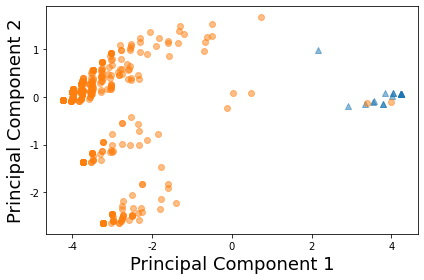

test1GEO


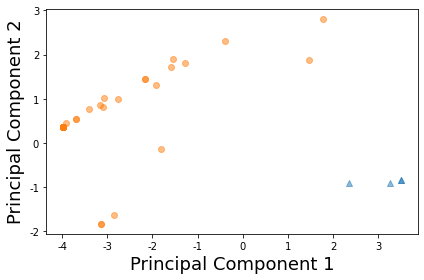

test2GEO


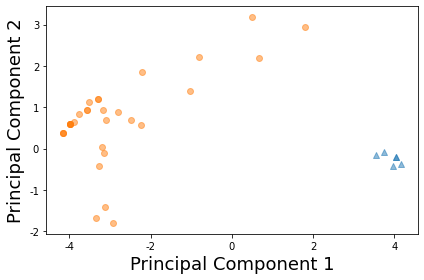

In [23]:
pca = PrincipalComponentAnalysis(n_components=2)

etc_train = pair.dftopair(x_train,selectedRNA['mRNA1'],selectedRNA['mRNA2'],diff)
pca.fit(etc_train)

legs = ['control','case']
for x_,y_,ds in zip(x_test,y_test,testname):
    etc_ = pair.dftopair(x_,selectedRNA['mRNA1'],selectedRNA['mRNA2'],diff)
    pca.fit(etc_)
    X_pca = pca.transform(etc_)

    for lab, mak,leg in zip((0, 1),('^', 'o'),legs):
        plt.scatter(X_pca[y_==lab, 0],
                    X_pca[y_==lab, 1],
                    label=ds,
                    marker=mak,
#                     c=col,
                   alpha = 1/2)
    print(ds)
    plt.xlabel('Principal Component 1', fontsize=18)
    plt.ylabel('Principal Component 2', fontsize=18)
    # plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
    plt.tight_layout()
#     plt.savefig('PCA.png',dpi=600)
    plt.show()

test2GEO


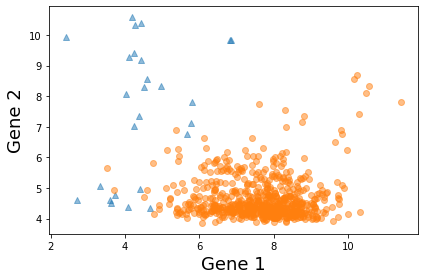

test2GEO


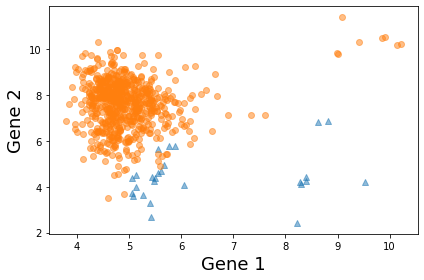

test2GEO


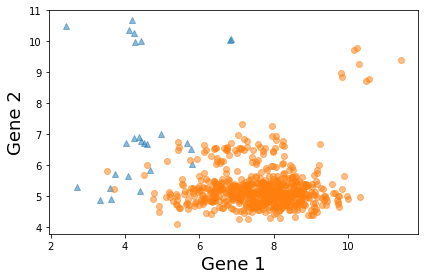

test2GEO


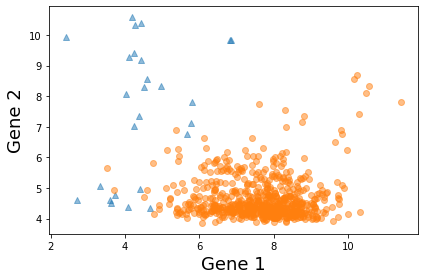

test2GEO


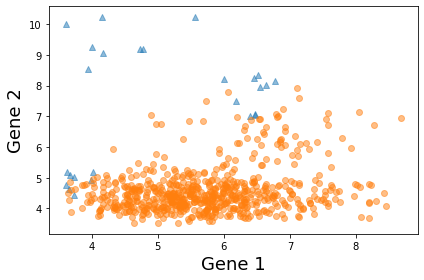

test2GEO


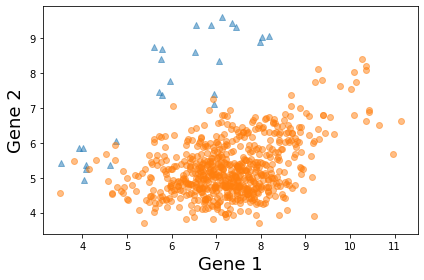

test2GEO


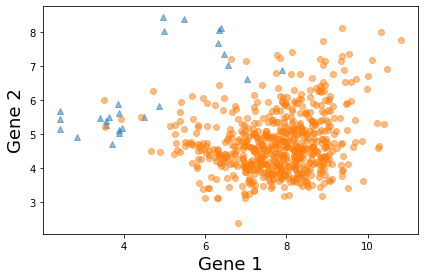

test2GEO


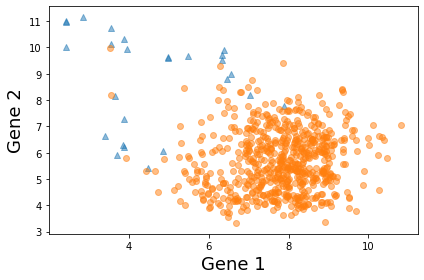

test2GEO


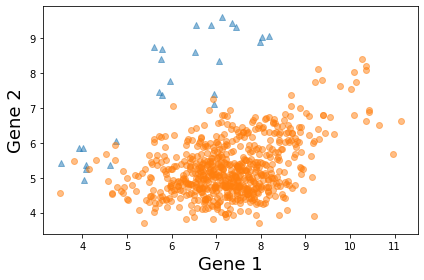

test2GEO


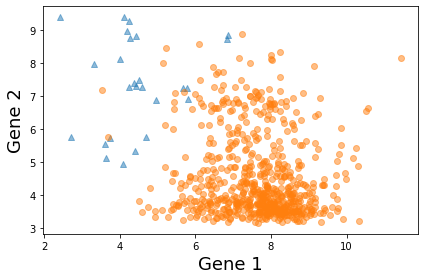

test2GEO


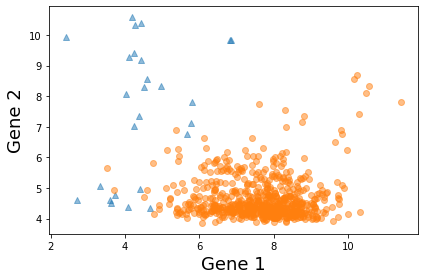

test2GEO


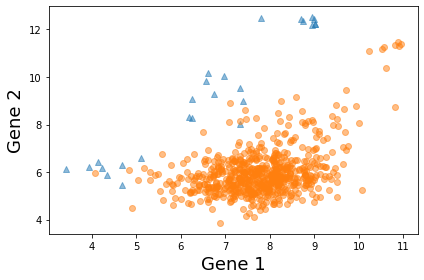

test2GEO


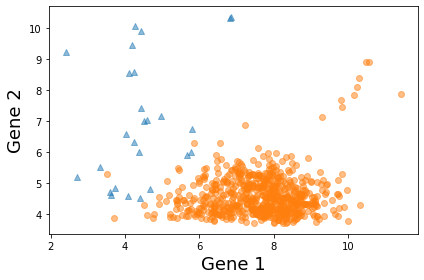

test2GEO


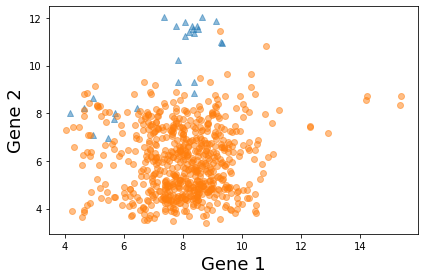

test2GEO


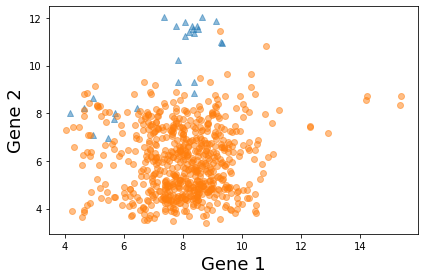

test2GEO


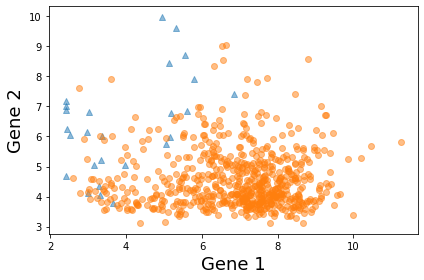

test2GEO


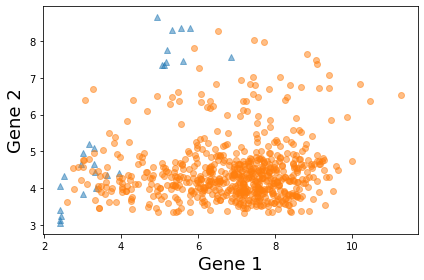

test2GEO


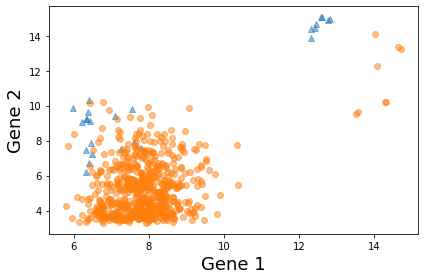

In [24]:
for i in range(len(selectedRNA['mRNA1'])):

    for lab, mak,leg in zip((0, 1),('^', 'o'),legs):
        plt.scatter(x_train.loc[selectedRNA['mRNA1'].values[i]].values[y_train==lab],
                    x_train.loc[selectedRNA['mRNA2'].values[i]].values[y_train==lab],
                    label=ds,
                    marker=mak,
#                     c=col,
                   alpha = 1/2)
    print(ds)
    plt.xlabel('Gene 1', fontsize=18)
    plt.ylabel('Gene 2', fontsize=18)
    # plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
    plt.tight_layout()
#     plt.savefig('PCA.png',dpi=600)
    plt.show()

In [25]:
sum(y_train == 0)

26

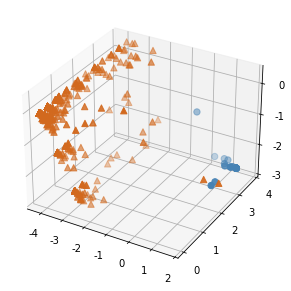

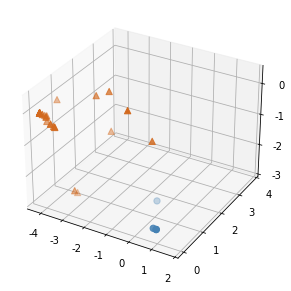

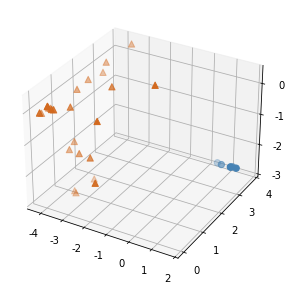

In [26]:
pca = PrincipalComponentAnalysis(n_components=3)

etc_train = pair.dftopair(x_train,selectedRNA['mRNA1'],selectedRNA['mRNA2'],diff)
pca.fit(etc_train)

for x_,y_,ds in zip(x_test,y_test,testname):
    etc_ = pair.dftopair(x_,selectedRNA['mRNA1'],selectedRNA['mRNA2'],diff)
#     pca.fit(etc_)
    X_pca = pca.transform(etc_)
    
    pt_df = pd.DataFrame( { 'pc 1':np.squeeze(X_pca[:,0]),
                                'pc 2':np.squeeze(X_pca[:,2]),
                                'pc 3':np.squeeze(X_pca[:,1]),
                                'label':y_}, 
                                columns = ['pc 1','pc 2','pc 3','label'])
    plt.figure()
    ax = plt.axes(projection="3d")
    pt_df0 = pt_df[pt_df['label']==0]
    pt_df1 = pt_df[pt_df['label']==1]
    ax.scatter3D(pt_df1['pc 1'], pt_df1['pc 2'], pt_df1['pc 3'],c= 'chocolate', marker = '^',s=40)
    ax.scatter3D(pt_df0['pc 1'], pt_df0['pc 2'], pt_df0['pc 3'],c= 'steelblue',marker = 'o',s=40)
    
    plt.xlim(-4.5, 2)
    # ax.set_xticks([-1, 0, 1])
    plt.ylim(-0.2, 4)
    ax.set_yticks([0,1,2,3,4])
    ax.set_zlim(-3,0.5)
    ax.set_zticks([-3,-2,-1,0])
    plt.tight_layout(pad=1)
    plt.savefig('./pairplot/'+ds+'scatterplot.png',dpi=150)
    plt.show()

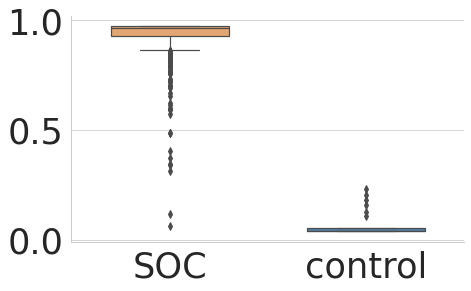

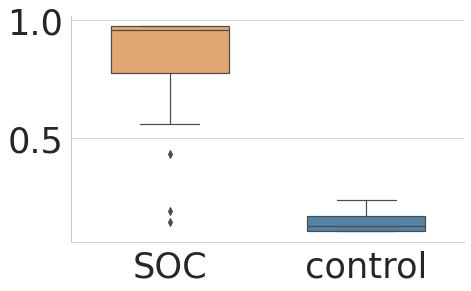

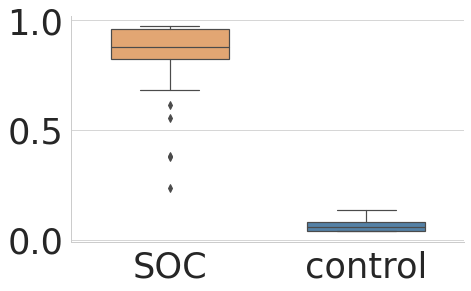

In [27]:
for x_,y_,ds in zip(x_test,y_test,testname):
    etc_test = pair.dftopair(x_,RNA['mRNA1'],RNA['mRNA2'], diff)
    pdt = clf.predict(etc_test)
    np.savetxt(ds+' soc index.txt',pdt)

    pdt_df = pd.DataFrame( {'expression level':pdt,'label':y_}, columns = ['expression level','label'])
    pdt_df.replace(to_replace={'label':1}, value='SOC', inplace=True)
    pdt_df.replace(to_replace={'label':0}, value='control', inplace=True)
    
    sns.set(context='paper',style='whitegrid',font_scale=4, palette='deep')
    mycolor = {'SOC': 'sandybrown', 'control': 'steelblue'}
    g = sns.catplot(x='label', y='expression level', kind='box',order=['SOC','control'],
                    data=pdt_df, width=0.6, aspect=1.5,palette=mycolor)
    g.set(xlabel=None,ylabel=None)
#     plt.savefig('./pairplot/'+ds+'barplot.png',dpi=100)

In [28]:
for x_,y_,ds in zip(x_test,y_test,testname):
    etc_test = pair.dftopair(x_,RNA['mRNA1'],RNA['mRNA2'], diff)
    pred = clf.predict(etc_test)>0.2
    
    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_, pred).ravel()
    print(ds,'\ntp, fp, fn, tn:')
    print(tp, fp, fn, tn)
    
    # Accuracy
    print('accuracy:',accuracy_score(y_, pred))
    
    # Recall
    print('sensitivity:',tp / (tp + fn))
    
    # Sepcificity
    print('sepcificity:',tn / (tn + fp),'\n')

train 
tp, fp, fn, tn:
644 2 2 24
accuracy: 0.9940476190476191
sensitivity: 0.9969040247678018
sepcificity: 0.9230769230769231 

test1GEO 
tp, fp, fn, tn:
39 1 2 3
accuracy: 0.9333333333333333
sensitivity: 0.9512195121951219
sepcificity: 0.75 

test2GEO 
tp, fp, fn, tn:
32 0 0 6
accuracy: 1.0
sensitivity: 1.0
sepcificity: 1.0 



In [29]:
etc_test = pair.dftopair(df8,RNA['mRNA1'],RNA['mRNA2'], diff)
pred = clf.predict(etc_test)


def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(lab8,pred)
threshold

[0.42017598672643475]

In [30]:
# blood
etc_test = pair.dftopair(df8,RNA['mRNA1'],RNA['mRNA2'], diff)
pred = clf.predict(etc_test)>0.42017598672643475

tn, fp, fn, tp = confusion_matrix(lab8, pred).ravel()
print('tp, fp, fn, tn:')
print(tp, fp, fn, tn)

# Accuracy
print('accuracy:',accuracy_score(lab8, pred))

# Recall
print('sensitivity:',tp / (tp + fn))

# Sepcificity
print('sepcificity:',tn / (tn + fp),'\n')

tp, fp, fn, tn:
5 2 3 7
accuracy: 0.7058823529411765
sensitivity: 0.625
sepcificity: 0.7777777777777778 



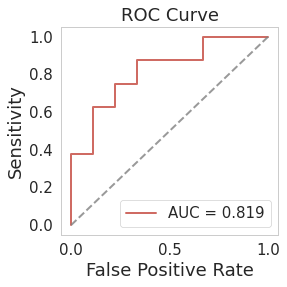

2


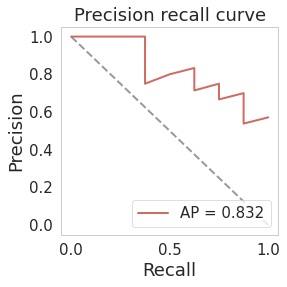

In [33]:
# x_test = [x_train, x_test1,x_test2]
# y_test = [y_train, y_test1,y_test2]
# testname = ["train","test1GEO","test2GEO"]

x_test = [df8]
y_test = [lab8]
testname = ["blood"]

i = 1
# plt.figure(figsize = (15,7))
for x_,y_,ds in zip(x_test,y_test,testname):
    etc_test = pair.dftopair(x_,RNA['mRNA1'],RNA['mRNA2'], diff)
    pred = clf.predict(etc_test)
    
    plt.figure(figsize = (4,4))
#     plt.subplot(2,3,i)
    
    plt.rc('xtick', labelsize=15)     
    plt.rc('ytick', labelsize=15)
    
    plt.grid(False)

    fpr, tpr, _ = metrics.roc_curve(y_, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = {0:0.3f}'.format(roc_auc), linewidth=2,color='#CF6B63')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,color='gray', alpha=.8)

    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.title('ROC Curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=15)
    plt.tight_layout(pad=0.2)
    plt.savefig('./pairplot/'+ds+'_auc.png',dpi=100)
    plt.show()
    
    
    plt.figure(figsize = (4,4))
#     plt.subplot(2,3,i+3)
    pre, rec, _ = metrics.precision_recall_curve(y_, pred)
    prc = metrics.average_precision_score(y_, pred)
    plt.plot(rec, pre, label='AP = {0:0.3f}'.format(prc), linewidth=2,color='#CF6B63')
    plt.plot([1, 0], [0, 1], linestyle='--', lw=2,color='gray', alpha=.8)
    
    plt.grid(False)
#     plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision recall curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=15)
    plt.tight_layout(pad=0.2)
    plt.savefig('./pairplot/'+ds+'_prc.png',dpi=100)
    
    
    i = i +1
    print(i)
    
# plt.tight_layout(pad=0.4)
# plt.savefig('./pairplot/auc_prc.png',dpi=100)
# plt.show()

In [34]:
# 18 pair value

extraction = x_train.loc[selectedRNA['mRNA1']].values - x_train.loc[selectedRNA['mRNA2']].values
np.savetxt('./18pairExtraction.txt',extraction,delimiter='\t')

etc_test = pair.dftopair(x_train,selectedRNA['mRNA1'],selectedRNA['mRNA2'], diff)
np.savetxt('./18pairConvert.txt',etc_test.T,delimiter='\t')
np.savetxt('./18pairLabel.txt',y_train,delimiter='\t')

# Prognosis

TOP2A :  MFAP4
>0:  571
>0:  12


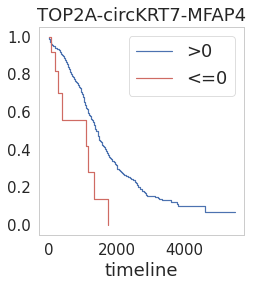

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.73 0.01      7.52

PRKCI :  SFRP4
>0:  564
>0:  19


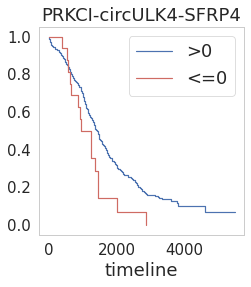

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.78 0.03      5.12

In [35]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

df_tcga = pd.read_csv('./ocRMA/HTHG584survival.txt',sep = "\t", index_col=0,header = 0)
lab = pd.read_csv('./oclabel/tcga584survival.txt',sep = "\t", index_col=1,header=0)
lab = lab[['OS.time','OS']]
lab = lab.drop(index='TCGA.36.2533.01')
df_tcga = df_tcga.drop(columns='TCGA.36.2533.01')

df_tcga = df_tcga.loc[comidx]
# x_ = df_tcga.to_numpy().T

# etc_test = pair.dftopair(df_tcga,RNA['mRNA1'],RNA['mRNA2'], diff)
# pdt = clf.predict(etc_test)

for j in [9,17]:
    
    pdt = pair.dftopair(df_tcga,selectedRNA['mRNA1'].reset_index(drop=True)[j],selectedRNA['mRNA2'].reset_index(drop=True)[j], diff)
    print(selectedRNA['mRNA1'].reset_index(drop=True)[j],': ',selectedRNA['mRNA2'].reset_index(drop=True)[j])

    # for i in [0.5, 0.6, 0.7, 0.8, 0.9]:
    for i in [0]:

        plt.figure(figsize = (3.5,4))
        ix1 = (pdt >= i)
        print(">"+str(i)+": ", sum(ix1))
        ix0 = (pdt < i)
        print(">"+str(i)+": ", sum(ix0))
        kmf = KaplanMeierFitter()
        kmf.fit(lab['OS.time'][ix1], event_observed=lab['OS'][ix1], label='>{}'.format(i))
        ax = kmf.plot(ci_show=False)
        kmf.fit(lab['OS.time'][ix0], event_observed=lab['OS'][ix0], label='<={}'.format(i))
        ax = kmf.plot(ax=ax,ci_show=False,color='#CF6B63')
        pairtitle = selectedRNA['mRNA1'].reset_index(drop=True)[j]+'-'\
                    + 'circ' + selectedRNA['clRNA'].reset_index(drop=True)[j] + '-'\
                    + selectedRNA['mRNA2'].reset_index(drop=True)[j]
        plt.title(pairtitle, fontsize=18)
        plt.legend(fontsize=18)
        plt.xlabel('timeline',fontsize=18)
        plt.grid(False)
        plt.tight_layout(pad=0.2)
        plt.savefig('./pairplot/prognosis'+pairtitle+'.png',dpi=100)
        plt.show()

        #logrank_test
        results=logrank_test(lab['OS.time'][ix1],lab['OS.time'][ix0],event_observed_A=lab['OS'][ix1], event_observed_B=lab['OS'][ix0])
        results.print_summary()

In [36]:
selectedRNA

,clRNA,mRNA1,mRNA2,type,value_x,value_y,a,b,c,d,fdr
26035,CFL1,TOP2A,SNCA,circ,0.5294,0.7921,0,24,626,8,1.980390e-33
29554,COL1A2,MYO1E,TOP2A,circ,0.6508,0.6341,23,0,3,617,7.220300e-35
31163,COL1A2,TOP2A,CRADD,circ,0.6341,0.7376,0,25,594,9,1.980390e-33
31182,COL1A2,TOP2A,SNCA,circ,0.6341,0.8681,0,24,626,8,1.980390e-33
34234,DDAH1,TRIB3,MEF2C,circ,0.6212,0.7662,0,26,466,36,7.447151e-25
34910,DTL,PRC1,BBS4,circ,0.5249,0.9652,0,24,591,8,5.691479e-33
41497,HDGF,TPX2,GNE,circ,0.6739,0.8484,1,23,622,7,1.161923e-31
41504,HDGF,TPX2,PDGFD,circ,0.6739,0.6243,0,25,551,31,1.655681e-26
43188,HUNK,PRC1,BBS4,circ,0.7414,0.7128,0,24,591,8,5.691479e-33
45080,KRT7,TOP2A,MFAP4,circ,0.6263,0.5946,0,26,587,27,6.428753e-29
